<table class="table table-bordered">
    <tr>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 (Problem 1) - Sentiment Analysis Model  (Group)</h2><h3>AY2022/23 Semester</h3></th>
    </tr>
</table>

## GROUP COMPONENT
## SEO SHIN YOUN (BIDIRECTIONAL LSTM + GRU MODEL)
## This file illustrates how the Bidirectional LSTM + GRU model is improved progressively before the final Bidirectional LSTM + GRU model is added to the final model group file

In [1]:
# Import the Required Packages
import re
import tensorflow
import os
import numpy as np
import pandas as pd
from googletrans import Translator
from langdetect import detect
from nltk.corpus import stopwords
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks, regularizers
# Build the Model
from tensorflow.keras import optimizers
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Bidirectional

## Step 1 – Data Loading and Processing (Group)

### 1.1 Data Loading

In [2]:
dat = pd.read_csv('disneyplus_reviews.csv', delimiter=',')
texts = dat.loc[:,'content'].values 
score = dat.loc[:,'score'].values

In [3]:
texts[:20]

array(["It's a very good app PERFECT for family movie nights 🌙👌🏾😊",
       'Disney suck, I’m paying for two whole accounts with Hulu and espn and they won’t let me manage my account but allow a whole other person manage my account',
       'very nice 👍👍👍👍👍 I love it 💕💕💕💕💕', 'MARVEL!', 'rr rock a',
       'very good movie, it teaches that people of different ethnicity can unite for a common cause of helping others and all heroes come in different cultures.',
       'Great Movies and shows', 'ad a zfF ZOFRAN p',
       "It is a good streaming service, it's just when you accidentally press above the screen it goes back. Which is annoying but easy to deal with",
       'streams perfectly!', 'Enjoyed',
       'best shows, best movies, app works great.. excellence',
       "This is amazing on my samsung galaxy A10e. I can watch my favorite disney shows and movie's",
       'App is really bad too many bugs. Log in problems just not worth it. As expected from any Disney product.',
       'Ich 

In [4]:
score[:20]

array([5, 1, 5, 5, 2, 5, 5, 1, 4, 4, 4, 5, 5, 1, 1, 5, 5, 5, 1, 4],
      dtype=int64)

### 1.2 Data Processing


In [5]:
# to clean the text to lower case, remove tag, remove special character and number
def pre_process(text):
    
    text = str(text)
    
    # lowercase
    text=text.lower().strip()
    
    #remove html tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("[^A-Za-z]+"," ",text)
    
    return text

dat['content'] = dat['content'].apply(lambda x:pre_process(x))

In [6]:
dat.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,b6a61f47-142a-4fa7-8861-cac7db5395bf,Rylan-Tanya Bailey,https://play-lh.googleusercontent.com/a-/AFdZu...,it s a very good app perfect for family movie ...,5,0,2.9.1-rc1,2022-08-06 10:15:15,NaN,NaN
1,3c703684-6465-42db-b4b2-74465a1e7c9c,Lena Hollins,https://play-lh.googleusercontent.com/a/AItbvm...,disney suck i m paying for two whole accounts ...,1,0,2.3.2-rc1,2022-08-06 10:10:05,NaN,NaN
2,518ca9a9-de68-46c0-820e-89edb759b388,rodelia kitahira,https://play-lh.googleusercontent.com/a-/AFdZu...,very nice i love it,5,0,2.9.1-rc1,2022-08-06 10:01:21,NaN,NaN
3,0c3fceec-a9aa-4781-a81c-c67d6d68ff60,Kirt Klass,https://play-lh.googleusercontent.com/a-/AFdZu...,marvel,5,0,2.9.1-rc1,2022-08-06 09:57:32,NaN,NaN
4,c5517f5c-05f8-4d83-bc46-c38b846cd92d,Raquel Martinez,https://play-lh.googleusercontent.com/a/AItbvm...,rr rock a,2,0,2.9.1-rc1,2022-08-06 09:51:19,NaN,NaN


In [7]:
# Remove row with empty cSontents (Not english)
dat.replace(' ', np.nan, inplace=True)
dat.dropna(subset=['content'], inplace=True)

In [8]:
def english_identifier(text):
    lang = detect(text)
    if lang == "en":
        text = text
    else:
        text = " "
    return text

dat['content'] = dat['content'].apply(lambda x:english_identifier(x))

In [9]:
# Remove row with empty contents (Not english)
dat.replace(' ', np.nan, inplace=True)
dat.dropna(subset=['content'], inplace=True)

In [10]:
dat.tail(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
180188,72f1adf7-569d-4e04-a206-052f09f62edc,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,brings back all my childhood memories from sho...,5,0,1.1.3,2019-11-12 14:54:42,NaN,NaN
180189,8246f9f6-200e-4a4d-bd94-bb7a94bf5f5e,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,wow look out netflix disney is coming for you ...,5,0,1.1.3,2019-11-12 14:54:16,NaN,NaN
180190,fa12e8ea-f5b4-4947-a764-d8c7f739c3bb,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,easy to use and no bugs so far love it,5,2,1.1.3,2019-11-12 14:53:33,NaN,NaN
180191,955ee495-d1b6-4ccd-89b8-f0cbfda90bdc,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,so far it s amazing and totally worth the money,5,0,1.1.3,2019-11-12 14:53:15,NaN,NaN
180194,841da9d6-4731-47a7-bd07-61c11dd16f78,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,good content just please bring back kids incor...,4,2,1.1.3,2019-11-12 14:50:30,NaN,NaN
180195,0a0c945b-34cf-42ae-8f84-183d5abd2c8a,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,not working at puerto rico,1,0,1.1.3,2019-11-12 14:50:26,"Hi, we apologize for any issue you might be ha...",2019-12-24 01:32:14
180196,19dd7816-08fa-4f54-84e1-71c5bf29c186,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,incredible well done app disney has a winner w...,5,0,1.1.3,2019-11-12 14:47:29,NaN,NaN
180197,1e60fcab-2f4b-401f-84d9-e379ef9f6918,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,so far so good even allows you to download you...,5,0,1.1.3,2019-11-12 14:47:20,NaN,NaN
180198,9ca71b45-5c2c-4954-8286-d6922c763351,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,great start disney,5,0,1.1.3,2019-11-12 14:46:35,NaN,NaN
180199,cef15543-c3df-4888-b273-d593744a6cdf,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,very solid app it flows a lot like netflix,5,0,1.1.3,2019-11-12 14:45:49,NaN,NaN


In [11]:
unique_labels = dat.groupby('score').nunique()
print(unique_labels['content'])

score
1    40899
2    12002
3    11988
4    14126
5    50046
Name: content, dtype: int64


In [12]:
content_list = dat['content'].tolist()

In [13]:
df_1 = dat[dat['score']==1]
df_1.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
1,3c703684-6465-42db-b4b2-74465a1e7c9c,Lena Hollins,https://play-lh.googleusercontent.com/a/AItbvm...,disney suck i m paying for two whole accounts ...,1,0,2.3.2-rc1,2022-08-06 10:10:05,NaN,NaN
13,0a5f18b4-baba-4d6a-b740-aea6b68c9e23,Martin Amador,https://play-lh.googleusercontent.com/a-/AFdZu...,app is really bad too many bugs log in problem...,1,1,NaN,2022-08-06 08:58:24,NaN,NaN
18,94a1a100-0fae-496c-9eae-5343cf97c20b,Mark Brown,https://play-lh.googleusercontent.com/a/AItbvm...,as others have mentioned the app simply doesn ...,1,1,2.9.1-rc1,2022-08-06 08:29:01,NaN,NaN
27,80db9329-4908-44fe-9376-9dccc3d2867a,MICHELLS DIARIES,https://play-lh.googleusercontent.com/a-/AFdZu...,not working have been trying for over a week t...,1,1,2.9.1-rc1,2022-08-06 06:55:58,NaN,NaN
35,bc7b2037-c7d8-462b-8ae2-c87765797f71,Cassie Parke,https://play-lh.googleusercontent.com/a/AItbvm...,the app was working fine until a point when i ...,1,1,2.9.1-rc1,2022-08-06 05:57:08,NaN,NaN


In [14]:
df_2 = dat[dat['score']==2]
df_2.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
33,66c240f1-82bb-4cc0-8399-b4cb442136df,Carlos,https://play-lh.googleusercontent.com/a-/AFdZu...,this pos logs you out then tells me my log in ...,2,1,2.9.1-rc1,2022-08-06 06:31:05,NaN,NaN
34,2876f3da-7e6e-4537-9833-eebf21958a0f,Bob Cain,https://play-lh.googleusercontent.com/a/AItbvm...,it s great when it works i can only get it to ...,2,1,2.9.1-rc1,2022-08-06 06:01:00,NaN,NaN
37,f234fbf6-fd89-490e-b9e0-f9ea96c89ded,Marvin Daniel,https://play-lh.googleusercontent.com/a-/AFdZu...,i want to caniel it pleas dorp it thnak,2,0,2.8.0-rc2,2022-08-06 05:38:22,NaN,NaN
59,5be2964d-9f37-4b72-87bc-fc22daf882f0,Adam Hedges,https://play-lh.googleusercontent.com/a-/AFdZu...,good content but awful application crashes and...,2,0,2.9.1-rc1,2022-08-06 03:06:21,NaN,NaN
66,4d128299-557c-4471-8a0f-5381a7c8f56d,mario armendariz,https://play-lh.googleusercontent.com/a-/AFdZu...,lag with wifi,2,0,2.9.1-rc1,2022-08-06 02:25:11,NaN,NaN


In [17]:
df_3 = dat[dat['score']==3]
df_3.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
20,0a8fe624-c83d-40a3-a37b-28e868196c3e,Rhys Lavy,https://play-lh.googleusercontent.com/a-/AFdZu...,not really the best movies or shows on the app...,3,0,2.9.1-rc1,2022-08-06 07:52:30,NaN,NaN
22,9fe8d68f-212f-4cc0-8544-93e50aa2d78f,Marilyn Looper,https://play-lh.googleusercontent.com/a-/AFdZu...,will not download to tablet or pc only choices...,3,0,NaN,2022-08-06 07:31:49,NaN,NaN
30,987f24d6-266f-482d-9941-f6cf9f272f09,Justin Henry,https://play-lh.googleusercontent.com/a-/AFdZu...,wicked step father abuse slows and is still here,3,0,2.9.1-rc1,2022-08-06 06:46:44,NaN,NaN
89,ae6c82c9-5af7-4691-92f8-1babb1e6319e,Mindi Styn,https://play-lh.googleusercontent.com/a/AItbvm...,i love the disney plus service but the app is ...,3,0,2.9.1-rc1,2022-08-06 00:40:57,NaN,NaN
110,8b191412-6248-44a7-82ce-6ab169de9f6c,Alex,https://play-lh.googleusercontent.com/a/AItbvm...,please make the watchlist bigger now it s limi...,3,0,2.9.1-rc1,2022-08-05 21:45:57,NaN,NaN


In [18]:
df_4 = dat[dat['score']==4]
df_4.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
8,b9d36e18-2dd8-47d5-bfe4-526a8bd86a55,thaddeusc44,https://play-lh.googleusercontent.com/a-/AFdZu...,it is a good streaming service it s just when ...,4,0,2.9.1-rc1,2022-08-06 09:44:23,NaN,NaN
9,6d2d5548-916a-434e-95df-b745f9553620,Cesar Robles,https://play-lh.googleusercontent.com/a-/AFdZu...,streams perfectly,4,0,2.9.1-rc1,2022-08-06 09:43:07,NaN,NaN
19,33c75bab-a145-4dcc-970f-4ba8ddeb1835,Thomas Hatch,https://play-lh.googleusercontent.com/a/AItbvm...,i love it it good when you can watch it entime...,4,0,2.6.2-rc1,2022-08-06 08:11:19,NaN,NaN
24,c69a2d1f-2760-45a3-b088-b121e3761001,Daniel Dias,https://play-lh.googleusercontent.com/a-/AFdZu...,the app is good but there are so many errors c...,4,0,2.9.1-rc1,2022-08-06 07:16:28,NaN,NaN
32,9e355ca9-5f98-424e-9195-5bc2cd929997,Vladan Đuričanin,https://play-lh.googleusercontent.com/a-/AFdZu...,stars just because it doesn t yet have serbia...,4,0,NaN,2022-08-06 06:34:27,NaN,NaN


In [19]:
df_5 = dat[dat['score']==5]
df_5.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,b6a61f47-142a-4fa7-8861-cac7db5395bf,Rylan-Tanya Bailey,https://play-lh.googleusercontent.com/a-/AFdZu...,it s a very good app perfect for family movie ...,5,0,2.9.1-rc1,2022-08-06 10:15:15,NaN,NaN
5,82a8c221-85d9-4fed-9ce0-41609d4fe9e9,ANTHONY COOPER,https://play-lh.googleusercontent.com/a-/AFdZu...,very good movie it teaches that people of diff...,5,0,2.9.1-rc1,2022-08-06 09:47:20,NaN,NaN
6,8cd7f3cd-7784-48ec-82de-e4dcf0bd99ad,Magnus SaucerMan,https://play-lh.googleusercontent.com/a-/AFdZu...,great movies and shows,5,0,2.9.1-rc1,2022-08-06 09:46:24,NaN,NaN
11,65d2a028-90bb-4e23-a03f-56f2aae044f6,David Paul,https://play-lh.googleusercontent.com/a/AItbvm...,best shows best movies app works great excellence,5,0,2.9.1-rc1,2022-08-06 09:15:54,NaN,NaN
12,a02a4a82-e85a-4ccf-ba1b-5085ce511638,Juan Zelaya-Diaz,https://play-lh.googleusercontent.com/a-/AFdZu...,this is amazing on my samsung galaxy a e i can...,5,0,2.9.1-rc1,2022-08-06 09:02:08,NaN,NaN


In [20]:
df1_sampled = df_1.sample(n=10000,random_state = 2).copy()
df1_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 34696 to 11890
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10000 non-null  object
 1   userName              10000 non-null  object
 2   userImage             10000 non-null  object
 3   content               10000 non-null  object
 4   score                 10000 non-null  int64 
 5   thumbsUpCount         10000 non-null  int64 
 6   reviewCreatedVersion  8110 non-null   object
 7   at                    10000 non-null  object
 8   replyContent          700 non-null    object
 9   repliedAt             700 non-null    object
dtypes: int64(2), object(8)
memory usage: 859.4+ KB


In [21]:
df2_sampled = df_2.sample(n=10000,random_state = 2).copy()
df2_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 141979 to 152191
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10000 non-null  object
 1   userName              10000 non-null  object
 2   userImage             10000 non-null  object
 3   content               10000 non-null  object
 4   score                 10000 non-null  int64 
 5   thumbsUpCount         10000 non-null  int64 
 6   reviewCreatedVersion  8666 non-null   object
 7   at                    10000 non-null  object
 8   replyContent          278 non-null    object
 9   repliedAt             278 non-null    object
dtypes: int64(2), object(8)
memory usage: 859.4+ KB


In [22]:
df3_sampled = df_3.sample(n=10000,random_state = 2).copy()
df3_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 37486 to 153004
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10000 non-null  object
 1   userName              10000 non-null  object
 2   userImage             10000 non-null  object
 3   content               10000 non-null  object
 4   score                 10000 non-null  int64 
 5   thumbsUpCount         10000 non-null  int64 
 6   reviewCreatedVersion  8841 non-null   object
 7   at                    10000 non-null  object
 8   replyContent          244 non-null    object
 9   repliedAt             244 non-null    object
dtypes: int64(2), object(8)
memory usage: 859.4+ KB


In [23]:
df4_sampled = df_4.sample(n=10000,random_state = 2).copy()
df4_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 62586 to 148892
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10000 non-null  object
 1   userName              10000 non-null  object
 2   userImage             10000 non-null  object
 3   content               10000 non-null  object
 4   score                 10000 non-null  int64 
 5   thumbsUpCount         10000 non-null  int64 
 6   reviewCreatedVersion  8776 non-null   object
 7   at                    10000 non-null  object
 8   replyContent          151 non-null    object
 9   repliedAt             151 non-null    object
dtypes: int64(2), object(8)
memory usage: 859.4+ KB


In [24]:
df5_sampled = df_5.sample(n=10000,random_state = 2).copy()
df5_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 121671 to 92416
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10000 non-null  object
 1   userName              10000 non-null  object
 2   userImage             10000 non-null  object
 3   content               10000 non-null  object
 4   score                 10000 non-null  int64 
 5   thumbsUpCount         10000 non-null  int64 
 6   reviewCreatedVersion  8343 non-null   object
 7   at                    10000 non-null  object
 8   replyContent          41 non-null     object
 9   repliedAt             41 non-null     object
dtypes: int64(2), object(8)
memory usage: 859.4+ KB


In [25]:
#Create a dataframe that concatenates df0_sampled (not promoted) and df1(promoted employees)
df_new = pd.concat([df1_sampled, df2_sampled, df3_sampled, df4_sampled, df5_sampled], axis=0)
df_new['score'].value_counts()

1    10000
2    10000
3    10000
4    10000
5    10000
Name: score, dtype: int64

In [27]:
df_new.to_csv('filtered_downsampled_disneyplus_reviews.csv', index=False)

In [2]:
df = pd.read_csv('filtered_downsampled_disneyplus_reviews.csv')

In [3]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,2b0a11c7-5f8b-4a88-a429-65ee5b1618bd,shona lawrence,https://play-lh.googleusercontent.com/a-/AFdZu...,the actual disneyplus content love it the app ...,1,73,1.17.1,2021-09-17 23:06:13,NaN,NaN
1,ee25d0e6-38b8-4e4e-9a45-e417a0818af7,Roni Luv,https://play-lh.googleusercontent.com/a-/AFdZu...,it s in spanish i can t change the language,1,0,1.15.0,2021-10-19 05:10:00,NaN,NaN
2,14bc9ed1-5465-4110-93ca-cf57534616d1,Lethia Billie,https://play-lh.googleusercontent.com/a/AItbvm...,i keep getting that error messages no matter w...,1,2,1.8.0,2020-09-05 08:26:02,NaN,NaN
3,226d0c0a-eb98-4654-90e8-86d5f5a6ceb2,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,when it worked for days during the day free tr...,1,261,1.2.0,2019-12-27 10:58:08,NaN,NaN
4,e72833cb-1bd3-4e5e-b5ba-f03baf54dc79,Sandy Grant-Taylor,https://play-lh.googleusercontent.com/a/AItbvm...,it takes for ever if even to log on for a comp...,1,0,NaN,2021-05-22 18:23:48,NaN,NaN


In [4]:
df = df[["content", "score"]]

In [5]:
df.head()

,content,score
0,the actual disneyplus content love it the app ...,1
1,it s in spanish i can t change the language,1
2,i keep getting that error messages no matter w...,1
3,when it worked for days during the day free tr...,1
4,it takes for ever if even to log on for a comp...,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  50000 non-null  object
 1   score    50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


### 1.3 Data Sampling

In [7]:
text = df.loc[:,'content'].values
labels = df.loc[:,'score'].values
texts_cleaned = []
for i in text:
    texts_cleaned.append(str(i))

In [8]:
texts_cleaned

['the actual disneyplus content love it the app with which to watch the content not so much constantly getting an unable to connect to service which means i have to constantly have to uninstall and reinstall the app for the price we pay for subscription they least you can offer is a stable app from which to view it ',
 'it s in spanish i can t change the language',
 'i keep getting that error messages no matter what they tell me to do with my devices it s very frustrating that i can t watch my downloads ',
 'when it worked for days during the day free trial it was good haven t been able to stream let alone log in from my home internet connection since november th contacted them starting december st and many times thereafter issue is they are blocking my isp s ip address even my isp has contacted them they claim that they will have the ip white listed claimed they have escalated the ticket many times customer service is a joke seems they just say whatever they think you want to hear to 

In [9]:
score_list = []

for i in labels:
    i -= 1
    score_list.append(i)
        
score = np.array(score_list)

In [10]:
max_len = -1
stop_words = set(stopwords.words('english'))
tkList = []
filtered_sentence = []
for example in texts_cleaned:
    if len(example) > max_len:
        max_len = len(example)
        print('the maximum length of the text inputs is ', max_len)
        max_features = 15000

for s in texts_cleaned:
    tkList.append(nltk.word_tokenize(s))

for i in tkList:
    filtered_sentence.append([w for w in i if not w.lower() in stop_words])

filtered_list = [' '.join(x) for x in filtered_sentence]

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts_cleaned)
sequences = tokenizer.texts_to_sequences(filtered_list)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=50) #150

#labels = [0,1,2,3,4]
y = to_categorical(np.asarray(score))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

the maximum length of the text inputs is  315
the maximum length of the text inputs is  577
the maximum length of the text inputs is  1131
the maximum length of the text inputs is  1580
the maximum length of the text inputs is  2652
the maximum length of the text inputs is  2949
Shape of data tensor: (50000, 50)
Shape of label tensor: (50000, 5)


In [11]:
# Split the X & y into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.2)

## Step 2 – Develop a Sentiment Analysis Model (Individual: One Model Per Student)

### Bidirectional LSTM + GRU Model #1  (Student Name: Seo Shin Youn)

### 1. Base Model

In [12]:
modelBidirectionalLSTMGRU1 = Sequential()
modelBidirectionalLSTMGRU1.add(Embedding(max_features, 64, input_length=50))
modelBidirectionalLSTMGRU1.add(Bidirectional(layers.LSTM(64, return_sequences=True)))
modelBidirectionalLSTMGRU1.add(Bidirectional(layers.GRU(64, return_sequences=False)))
modelBidirectionalLSTMGRU1.add(Dense(5, activation='softmax'))
optimizer = optimizers.Adam(learning_rate = 0.0005)
modelBidirectionalLSTMGRU1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics =['acc'])
modelBidirectionalLSTMGRU1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            960000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 128)          66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 1,101,189
Trainable params: 1,101,189
Non-trainable params: 0
_________________________________________________________________


In [103]:
# Train the Model
earlystopping = callbacks.EarlyStopping(monitor='val_acc', mode='max', patience = 5)
history = modelBidirectionalLSTMGRU1.fit(x_train, y_train,
          batch_size=128,
          epochs=30,
          validation_split=0.2,
          callbacks=[earlystopping])

Epoch 1/30
250/250 [==============================] - 15s 37ms/step - loss: 1.3361 - acc: 0.3960 - val_loss: 1.1767 - val_acc: 0.4894
Epoch 2/30
250/250 [==============================] - 8s 31ms/step - loss: 1.0964 - acc: 0.5282 - val_loss: 1.1328 - val_acc: 0.5117
Epoch 3/30
250/250 [==============================] - 8s 30ms/step - loss: 1.0212 - acc: 0.5681 - val_loss: 1.1510 - val_acc: 0.5131
Epoch 4/30
250/250 [==============================] - 8s 32ms/step - loss: 0.9717 - acc: 0.5968 - val_loss: 1.1877 - val_acc: 0.5096
Epoch 5/30
250/250 [==============================] - 8s 34ms/step - loss: 0.9279 - acc: 0.6200 - val_loss: 1.2061 - val_acc: 0.4941
Epoch 6/30
250/250 [==============================] - 8s 33ms/step - loss: 0.8859 - acc: 0.6441 - val_loss: 1.2639 - val_acc: 0.4874
Epoch 7/30
250/250 [==============================] - 8s 32ms/step - loss: 0.8455 - acc: 0.6658 - val_loss: 1.3063 - val_acc: 0.4805
Epoch 8/30
250/250 [==============================] - 8s 32ms/step -

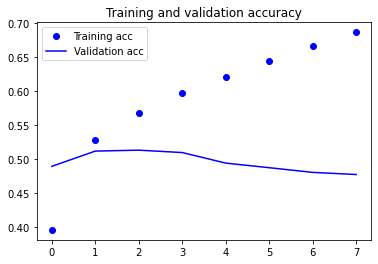

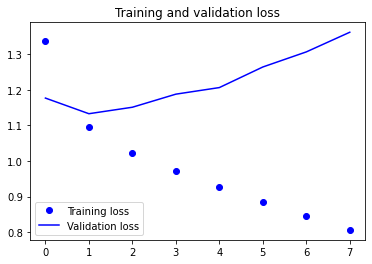

In [104]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline
# history = modelBidirectionalLSTMGRU1.history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [105]:
# Save the Model
modelBidirectionalLSTMGRU1.save('modelBidirectionalLSTMGRU1.h5')

### 2. Tackle Validation Accuracy Decreasing By Reducing Learning Rate (0.0005 to 0.000008)

In [16]:
modelBidirectionalLSTMGRU2 = Sequential()
modelBidirectionalLSTMGRU2.add(Embedding(max_features, 64, input_length=50))
modelBidirectionalLSTMGRU2.add(Bidirectional(layers.LSTM(64, return_sequences=True)))
modelBidirectionalLSTMGRU2.add(Bidirectional(layers.GRU(64, return_sequences=False)))
modelBidirectionalLSTMGRU2.add(Dense(5, activation='softmax'))
optimizer = optimizers.Adam(learning_rate = 0.000008)
modelBidirectionalLSTMGRU2.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics =['acc'])
modelBidirectionalLSTMGRU2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 64)            960000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 128)          66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 1,101,189
Trainable params: 1,101,189
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Train the Model
earlystopping = callbacks.EarlyStopping(monitor='val_acc', mode='max', patience = 5)
history = modelBidirectionalLSTMGRU2.fit(x_train, y_train,
          batch_size=128,
          epochs=30,
          validation_split=0.2,
          callbacks=[earlystopping])

Epoch 1/30
250/250 [==============================] - 16s 34ms/step - loss: 1.6086 - acc: 0.2178 - val_loss: 1.6075 - val_acc: 0.2820
Epoch 2/30
250/250 [==============================] - 7s 27ms/step - loss: 1.6062 - acc: 0.2825 - val_loss: 1.6044 - val_acc: 0.2909
Epoch 3/30
250/250 [==============================] - 7s 27ms/step - loss: 1.6021 - acc: 0.2883 - val_loss: 1.5980 - val_acc: 0.2846
Epoch 4/30
250/250 [==============================] - 7s 28ms/step - loss: 1.5923 - acc: 0.2764 - val_loss: 1.5824 - val_acc: 0.2734
Epoch 5/30
250/250 [==============================] - 8s 32ms/step - loss: 1.5751 - acc: 0.2762 - val_loss: 1.5635 - val_acc: 0.2833
Epoch 6/30
250/250 [==============================] - 8s 32ms/step - loss: 1.5559 - acc: 0.2903 - val_loss: 1.5446 - val_acc: 0.2924
Epoch 7/30
250/250 [==============================] - 7s 29ms/step - loss: 1.5369 - acc: 0.3006 - val_loss: 1.5278 - val_acc: 0.2998
Epoch 8/30
250/250 [==============================] - 8s 30ms/step -

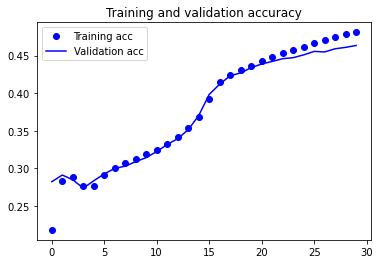

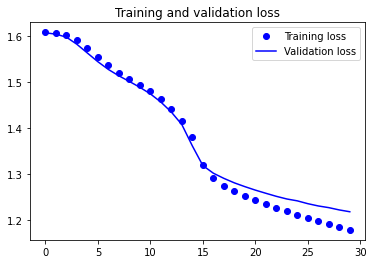

In [18]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline
# history = modelBidirectionalLSTMGRU1.history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# Save the Model
modelBidirectionalLSTMGRU2.save('modelBidirectionalLSTMGRU2.h5')

### 3. Increase Validation Accuracy  - Add More Layers + Increase in Batch Size + Increase in Epoch

In [22]:
modelBidirectionalLSTMGRU3 = Sequential()
modelBidirectionalLSTMGRU3.add(Embedding(max_features, 64, input_length=50))
modelBidirectionalLSTMGRU3.add(Bidirectional(layers.LSTM(64, return_sequences=True)))
modelBidirectionalLSTMGRU3.add(Bidirectional(layers.LSTM(64, return_sequences=True)))
modelBidirectionalLSTMGRU3.add(Bidirectional(layers.GRU(64, return_sequences=True)))
modelBidirectionalLSTMGRU3.add(Bidirectional(layers.GRU(64, return_sequences=False)))
modelBidirectionalLSTMGRU3.add(Dense(5, activation='softmax'))
optimizer = optimizers.Adam(learning_rate = 0.000008)
modelBidirectionalLSTMGRU3.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics =['acc'])
modelBidirectionalLSTMGRU3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 64)            960000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 50, 128)          66048     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 50, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 50, 128)          74496     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 128)              74496     
 onal)                                                

In [23]:
# Train the Model
earlystopping = callbacks.EarlyStopping(monitor='val_acc', mode='max', patience = 15)
history = modelBidirectionalLSTMGRU3.fit(x_train, y_train,
          batch_size=512,
          epochs= 100,
          validation_split=0.2,
          callbacks=[earlystopping])

Epoch 1/100
63/63 [==============================] - 23s 139ms/step - loss: 1.6089 - acc: 0.1950 - val_loss: 1.6083 - val_acc: 0.2373
Epoch 2/100
63/63 [==============================] - 5s 78ms/step - loss: 1.6077 - acc: 0.2274 - val_loss: 1.6069 - val_acc: 0.2376
Epoch 3/100
63/63 [==============================] - 5s 80ms/step - loss: 1.6061 - acc: 0.2476 - val_loss: 1.6048 - val_acc: 0.2616
Epoch 4/100
63/63 [==============================] - 5s 81ms/step - loss: 1.6037 - acc: 0.2665 - val_loss: 1.6016 - val_acc: 0.2722
Epoch 5/100
63/63 [==============================] - 5s 80ms/step - loss: 1.5997 - acc: 0.2691 - val_loss: 1.5960 - val_acc: 0.2726
Epoch 6/100
63/63 [==============================] - 5s 80ms/step - loss: 1.5930 - acc: 0.2724 - val_loss: 1.5870 - val_acc: 0.2739
Epoch 7/100
63/63 [==============================] - 5s 80ms/step - loss: 1.5827 - acc: 0.2765 - val_loss: 1.5745 - val_acc: 0.2775
Epoch 8/100
63/63 [==============================] - 5s 80ms/step - loss: 

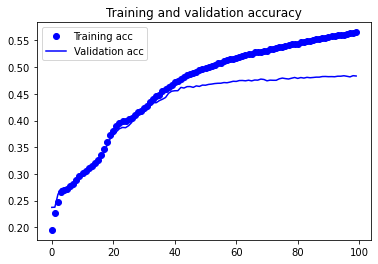

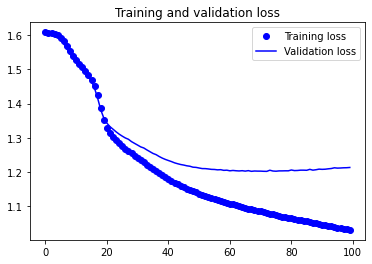

In [24]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
# Save the Model
modelBidirectionalLSTMGRU3.save('modelBidirectionalLSTMGRU3.h5')

### 4. Increase number of Units Per Bidirectional Layer

In [19]:
modelBidirectionalLSTMGRU4 = Sequential()
modelBidirectionalLSTMGRU4.add(Embedding(max_features, 128, input_length=50))
modelBidirectionalLSTMGRU4.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
modelBidirectionalLSTMGRU4.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
modelBidirectionalLSTMGRU4.add(Bidirectional(layers.GRU(128, return_sequences=True)))
modelBidirectionalLSTMGRU4.add(Bidirectional(layers.GRU(128, return_sequences=False)))
modelBidirectionalLSTMGRU4.add(Dense(5, activation='softmax'))
optimizer = optimizers.Adam(learning_rate = 0.000008)
modelBidirectionalLSTMGRU4.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics =['acc'])
modelBidirectionalLSTMGRU4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 128)           1920000   
                                                                 
 bidirectional_10 (Bidirecti  (None, 50, 256)          263168    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 50, 256)          394240    
 onal)                                                           
                                                                 
 bidirectional_12 (Bidirecti  (None, 50, 256)          296448    
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 256)              296448    
 onal)                                                

In [20]:
# Train the Model
earlystopping = callbacks.EarlyStopping(monitor='val_acc', mode='max', patience = 5)
history = modelBidirectionalLSTMGRU4.fit(x_train, y_train,
          batch_size=512,
          epochs=50,
          validation_split=0.2,
          callbacks=[earlystopping])

Epoch 1/50
63/63 [==============================] - 33s 259ms/step - loss: 1.6087 - acc: 0.2132 - val_loss: 1.6076 - val_acc: 0.2206
Epoch 2/50
63/63 [==============================] - 12s 195ms/step - loss: 1.6060 - acc: 0.2369 - val_loss: 1.6043 - val_acc: 0.2339
Epoch 3/50
63/63 [==============================] - 12s 196ms/step - loss: 1.6013 - acc: 0.2456 - val_loss: 1.5975 - val_acc: 0.2470
Epoch 4/50
63/63 [==============================] - 12s 197ms/step - loss: 1.5909 - acc: 0.2559 - val_loss: 1.5828 - val_acc: 0.2522
Epoch 5/50
63/63 [==============================] - 12s 197ms/step - loss: 1.5713 - acc: 0.2701 - val_loss: 1.5588 - val_acc: 0.2745
Epoch 6/50
63/63 [==============================] - 12s 198ms/step - loss: 1.5459 - acc: 0.2892 - val_loss: 1.5336 - val_acc: 0.2894
Epoch 7/50
63/63 [==============================] - 12s 198ms/step - loss: 1.5257 - acc: 0.3002 - val_loss: 1.5181 - val_acc: 0.2951
Epoch 8/50
63/63 [==============================] - 13s 199ms/step - 

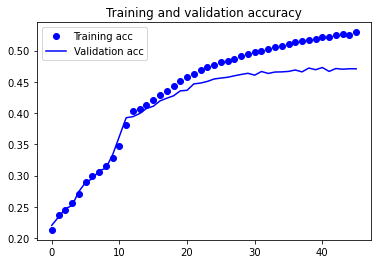

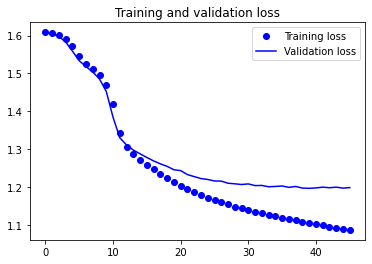

In [21]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
# Save the Model
modelBidirectionalLSTMGRU4.save('modelBidirectionalLSTMGRU4.h5')

### 5. Add Relu Dense Layer

In [14]:
modelBidirectionalLSTMGRU5 = Sequential()
modelBidirectionalLSTMGRU5.add(Embedding(max_features, 128, input_length=50))
modelBidirectionalLSTMGRU5.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
modelBidirectionalLSTMGRU5.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
modelBidirectionalLSTMGRU5.add(Bidirectional(layers.GRU(128, return_sequences=True)))
modelBidirectionalLSTMGRU5.add(Bidirectional(layers.GRU(128, return_sequences=False)))
modelBidirectionalLSTMGRU5.add(Dense(512, activation='relu'))
modelBidirectionalLSTMGRU5.add(Dense(5, activation='softmax'))
optimizer = optimizers.Adam(learning_rate = 0.000008)
modelBidirectionalLSTMGRU5.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics =['acc'])
modelBidirectionalLSTMGRU5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           1920000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 256)          263168    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 50, 256)          394240    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 256)          296448    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              296448    
 nal)                                                 

In [24]:
# Train the Model
earlystopping = callbacks.EarlyStopping(monitor='val_acc', mode='max', patience = 5)
history = modelBidirectionalLSTMGRU5.fit(x_train, y_train,
          batch_size=512,
          epochs=50,
          validation_split=0.2,
          callbacks=[earlystopping])

Epoch 1/50
63/63 [==============================] - 33s 257ms/step - loss: 1.6088 - acc: 0.2348 - val_loss: 1.6076 - val_acc: 0.2809
Epoch 2/50
63/63 [==============================] - 12s 195ms/step - loss: 1.6058 - acc: 0.2901 - val_loss: 1.6038 - val_acc: 0.2760
Epoch 3/50
63/63 [==============================] - 12s 196ms/step - loss: 1.5996 - acc: 0.2816 - val_loss: 1.5945 - val_acc: 0.2739
Epoch 4/50
63/63 [==============================] - 12s 197ms/step - loss: 1.5848 - acc: 0.2790 - val_loss: 1.5739 - val_acc: 0.2760
Epoch 5/50
63/63 [==============================] - 12s 197ms/step - loss: 1.5592 - acc: 0.2895 - val_loss: 1.5445 - val_acc: 0.2889
Epoch 6/50
63/63 [==============================] - 12s 198ms/step - loss: 1.5348 - acc: 0.2989 - val_loss: 1.5265 - val_acc: 0.2961
Epoch 7/50
63/63 [==============================] - 12s 198ms/step - loss: 1.5224 - acc: 0.3017 - val_loss: 1.5171 - val_acc: 0.2976
Epoch 8/50
63/63 [==============================] - 13s 199ms/step - 

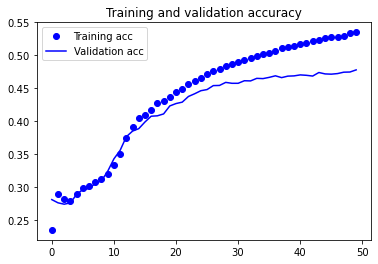

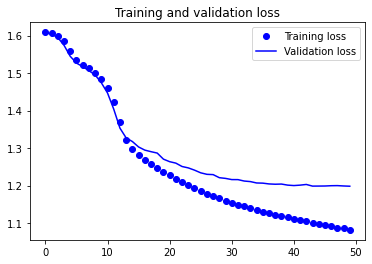

In [25]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
# Save the Model
modelBidirectionalLSTMGRU5.save('modelBidirectionalLSTMGRU5.h5')

### 6. Resequencing Model Architecture

In [12]:
modelBidirectionalLSTMGRU6 = Sequential()
modelBidirectionalLSTMGRU6.add(Embedding(max_features, 128, input_length=50))
modelBidirectionalLSTMGRU6.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
modelBidirectionalLSTMGRU6.add(Bidirectional(layers.GRU(128, return_sequences=True)))
modelBidirectionalLSTMGRU6.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
modelBidirectionalLSTMGRU6.add(Bidirectional(layers.GRU(128, return_sequences=False)))
modelBidirectionalLSTMGRU6.add(Dense(512, activation='relu'))
modelBidirectionalLSTMGRU6.add(Dense(5, activation='softmax'))
optimizer = optimizers.Adam(learning_rate = 0.000008)
modelBidirectionalLSTMGRU6.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics =['acc'])
modelBidirectionalLSTMGRU6.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 128)           1920000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 256)          263168    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 50, 256)          296448    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 50, 256)          394240    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 256)              296448    
 nal)                                                 

In [13]:
# Train the Model
earlystopping = callbacks.EarlyStopping(monitor='val_acc', mode='max', patience = 15)
history = modelBidirectionalLSTMGRU6.fit(x_train, y_train,
          batch_size=512,
          epochs=30,
          validation_split=0.2,
          callbacks=[earlystopping])

Epoch 1/30
63/63 [==============================] - 34s 268ms/step - loss: 1.6084 - acc: 0.2331 - val_loss: 1.6076 - val_acc: 0.2719
Epoch 2/30
63/63 [==============================] - 12s 193ms/step - loss: 1.6055 - acc: 0.2781 - val_loss: 1.6038 - val_acc: 0.2699
Epoch 3/30
63/63 [==============================] - 12s 193ms/step - loss: 1.5988 - acc: 0.2761 - val_loss: 1.5941 - val_acc: 0.2704
Epoch 4/30
63/63 [==============================] - 12s 194ms/step - loss: 1.5830 - acc: 0.2748 - val_loss: 1.5733 - val_acc: 0.2720
Epoch 5/30
63/63 [==============================] - 12s 195ms/step - loss: 1.5571 - acc: 0.2800 - val_loss: 1.5479 - val_acc: 0.2758
Epoch 6/30
63/63 [==============================] - 12s 195ms/step - loss: 1.5363 - acc: 0.2932 - val_loss: 1.5336 - val_acc: 0.2920
Epoch 7/30
63/63 [==============================] - 12s 195ms/step - loss: 1.5248 - acc: 0.3035 - val_loss: 1.5243 - val_acc: 0.2966
Epoch 8/30
63/63 [==============================] - 12s 196ms/step - 

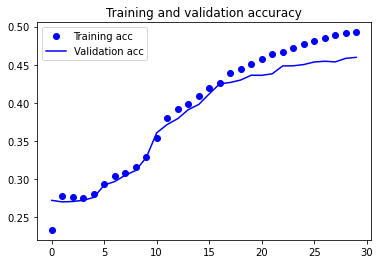

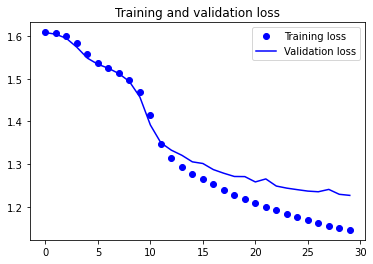

In [14]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
# Save the Model
modelBidirectionalLSTMGRU6.save('modelBidirectionalLSTMGRU6.h5')

### 7. Resquencing + Dropout Layers + Reduce Batch Size

In [22]:
modelBidirectionalLSTMGRU7 = Sequential()
modelBidirectionalLSTMGRU7.add(Embedding(max_features, 128, input_length=50))
modelBidirectionalLSTMGRU7.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
modelBidirectionalLSTMGRU7.add(layers.Dropout(0.5))
modelBidirectionalLSTMGRU7.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
modelBidirectionalLSTMGRU7.add(layers.Dropout(0.5))
modelBidirectionalLSTMGRU7.add(Bidirectional(layers.GRU(128, return_sequences=True)))
modelBidirectionalLSTMGRU7.add(layers.Dropout(0.5))
modelBidirectionalLSTMGRU7.add(Bidirectional(layers.GRU(128, return_sequences=False)))
modelBidirectionalLSTMGRU7.add(layers.Dropout(0.5))
modelBidirectionalLSTMGRU7.add(Dense(512, activation='relu'))
modelBidirectionalLSTMGRU7.add(layers.Dropout(0.5))
modelBidirectionalLSTMGRU7.add(Dense(5, activation='softmax'))
optimizer = optimizers.Adam(learning_rate = 0.000008)
modelBidirectionalLSTMGRU7.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics =['acc'])
modelBidirectionalLSTMGRU7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 128)           1920000   
                                                                 
 bidirectional_24 (Bidirecti  (None, 50, 256)          263168    
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_25 (Bidirecti  (None, 50, 256)          394240    
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_26 (Bidirecti  (None, 50, 256)         

In [23]:
# Train the Model
earlystopping = callbacks.EarlyStopping(monitor='val_acc', mode='max', patience = 15)
history = modelBidirectionalLSTMGRU7.fit(x_train, y_train,
          batch_size=256,
          epochs=50,
          validation_split=0.2,
          callbacks=[earlystopping])

Epoch 1/50
125/125 [==============================] - 33s 140ms/step - loss: 1.6091 - acc: 0.2062 - val_loss: 1.6080 - val_acc: 0.2095
Epoch 2/50
125/125 [==============================] - 12s 100ms/step - loss: 1.6074 - acc: 0.2268 - val_loss: 1.6051 - val_acc: 0.2610
Epoch 3/50
125/125 [==============================] - 12s 100ms/step - loss: 1.6030 - acc: 0.2538 - val_loss: 1.5970 - val_acc: 0.2580
Epoch 4/50
125/125 [==============================] - 13s 101ms/step - loss: 1.5911 - acc: 0.2607 - val_loss: 1.5796 - val_acc: 0.2609
Epoch 5/50
125/125 [==============================] - 13s 104ms/step - loss: 1.5723 - acc: 0.2763 - val_loss: 1.5569 - val_acc: 0.2752
Epoch 6/50
125/125 [==============================] - 13s 102ms/step - loss: 1.5500 - acc: 0.2883 - val_loss: 1.5370 - val_acc: 0.2856
Epoch 7/50
125/125 [==============================] - 13s 101ms/step - loss: 1.5311 - acc: 0.2930 - val_loss: 1.5200 - val_acc: 0.2930
Epoch 8/50
125/125 [==============================] - 1

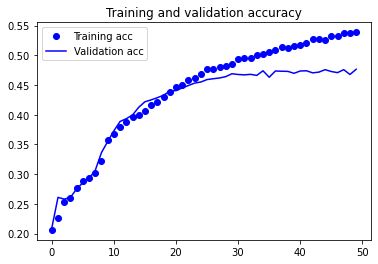

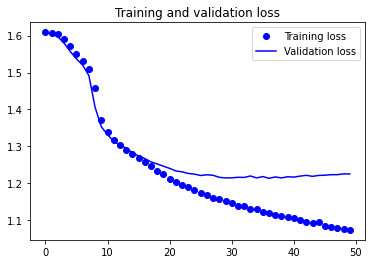

In [24]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
# Save the Model
modelBidirectionalLSTMGRU7.save('modelBidirectionalLSTMGRU7.h5')

### 8. Adding More Bidirectional Layers + Increase Dropout + Add Regularization

In [37]:
modelBidirectionalLSTMGRU8 = Sequential()

modelBidirectionalLSTMGRU8.add(Embedding(max_features, 128, input_length=50))
modelBidirectionalLSTMGRU8.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
modelBidirectionalLSTMGRU8.add(layers.Dropout(0.6))
modelBidirectionalLSTMGRU8.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
modelBidirectionalLSTMGRU8.add(layers.Dropout(0.6))
modelBidirectionalLSTMGRU8.add(Bidirectional(layers.LSTM(64, return_sequences=True, 
                                                         kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005))))
modelBidirectionalLSTMGRU8.add(layers.Dropout(0.6))
modelBidirectionalLSTMGRU8.add(Bidirectional(layers.GRU(128, return_sequences=True)))
modelBidirectionalLSTMGRU8.add(layers.Dropout(0.6))
modelBidirectionalLSTMGRU8.add(Bidirectional(layers.GRU(128, return_sequences=True)))
modelBidirectionalLSTMGRU8.add(layers.Dropout(0.6))
modelBidirectionalLSTMGRU8.add(Bidirectional(layers.GRU(64, return_sequences=False, 
                                                         kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005))))
modelBidirectionalLSTMGRU8.add(layers.Dropout(0.6))
modelBidirectionalLSTMGRU8.add(Dense(512, activation='relu'))
modelBidirectionalLSTMGRU8.add(layers.Dropout(0.6))
modelBidirectionalLSTMGRU8.add(Dense(5, activation='softmax'))
optimizer = optimizers.Adam(learning_rate = 0.00002)
modelBidirectionalLSTMGRU8.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics =['acc'])
modelBidirectionalLSTMGRU8.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 50, 128)           1920000   
                                                                 
 bidirectional_56 (Bidirecti  (None, 50, 256)          263168    
 onal)                                                           
                                                                 
 dropout_63 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_57 (Bidirecti  (None, 50, 256)          394240    
 onal)                                                           
                                                                 
 dropout_64 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_58 (Bidirecti  (None, 50, 128)        

In [38]:
# Train the Model
earlystopping = callbacks.EarlyStopping(monitor='val_acc', mode='max', patience = 15)
history = modelBidirectionalLSTMGRU8.fit(x_train, y_train,
          batch_size=512,
          epochs=30,
          validation_split=0.2,
          callbacks=[earlystopping])

Epoch 1/30
63/63 [==============================] - 42s 318ms/step - loss: 132.6813 - acc: 0.2032 - val_loss: 131.1319 - val_acc: 0.2150
Epoch 2/30
63/63 [==============================] - 15s 236ms/step - loss: 129.6665 - acc: 0.2242 - val_loss: 128.1357 - val_acc: 0.2199
Epoch 3/30
63/63 [==============================] - 15s 239ms/step - loss: 126.6872 - acc: 0.2376 - val_loss: 125.1701 - val_acc: 0.2504
Epoch 4/30
63/63 [==============================] - 15s 238ms/step - loss: 123.7362 - acc: 0.2599 - val_loss: 122.2285 - val_acc: 0.2769
Epoch 5/30
63/63 [==============================] - 15s 238ms/step - loss: 120.8066 - acc: 0.2882 - val_loss: 119.3011 - val_acc: 0.3075
Epoch 6/30
63/63 [==============================] - 15s 238ms/step - loss: 117.8973 - acc: 0.3055 - val_loss: 116.3792 - val_acc: 0.3332
Epoch 7/30
63/63 [==============================] - 15s 239ms/step - loss: 114.9747 - acc: 0.3442 - val_loss: 113.4809 - val_acc: 0.3672
Epoch 8/30
63/63 [=======================

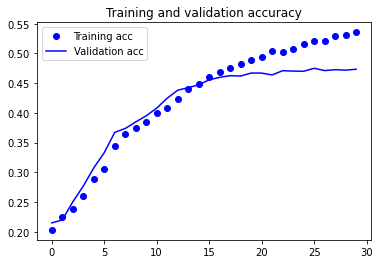

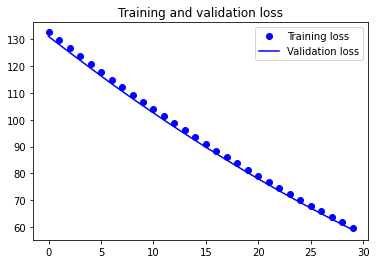

In [39]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
# Save the Model
modelBidirectionalLSTMGRU8.save('modelBidirectionalLSTMGRU8.h5')

### 9. Increase Regularization to Counter Overfitting + Reduce Batch Size

In [31]:
modelBidirectionalLSTMGRU9 = Sequential()
modelBidirectionalLSTMGRU9.add(Embedding(max_features, 128, input_length=50))
modelBidirectionalLSTMGRU9.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
modelBidirectionalLSTMGRU9.add(layers.Dropout(0.5))
modelBidirectionalLSTMGRU9.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
modelBidirectionalLSTMGRU9.add(layers.Dropout(0.5))
modelBidirectionalLSTMGRU9.add(Bidirectional(layers.LSTM(64, return_sequences=True, 
                                                         kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005))))
modelBidirectionalLSTMGRU9.add(layers.Dropout(0.5))
modelBidirectionalLSTMGRU9.add(Bidirectional(layers.GRU(128, return_sequences=True)))
modelBidirectionalLSTMGRU9.add(layers.Dropout(0.5))
modelBidirectionalLSTMGRU9.add(Bidirectional(layers.GRU(128, return_sequences=True)))
modelBidirectionalLSTMGRU9.add(layers.Dropout(0.5))
modelBidirectionalLSTMGRU9.add(Bidirectional(layers.GRU(64, return_sequences=False, 
                                                         kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005))))
modelBidirectionalLSTMGRU9.add(layers.Dropout(0.5))
modelBidirectionalLSTMGRU9.add(Dense(64, activation='relu'))
modelBidirectionalLSTMGRU9.add(layers.Dropout(0.2))
modelBidirectionalLSTMGRU9.add(Dense(5, activation='softmax', kernel_regularizer = regularizers.l2(0.01)))
optimizer = optimizers.Adam(learning_rate = 0.00002)
modelBidirectionalLSTMGRU9.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics =['acc'])

modelBidirectionalLSTMGRU9.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 128)           1920000   
                                                                 
 bidirectional_44 (Bidirecti  (None, 50, 256)          263168    
 onal)                                                           
                                                                 
 dropout_49 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_45 (Bidirecti  (None, 50, 256)          394240    
 onal)                                                           
                                                                 
 dropout_50 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_46 (Bidirecti  (None, 50, 128)         

In [32]:
# Train the Model
earlystopping = callbacks.EarlyStopping(monitor='val_acc', mode='max', patience = 15)
history = modelBidirectionalLSTMGRU9.fit(x_train, y_train,
          batch_size=128,
          epochs=60,
          validation_split=0.2,
          callbacks=[earlystopping])

Epoch 1/60
250/250 [==============================] - 46s 107ms/step - loss: 128.4554 - acc: 0.2286 - val_loss: 122.5546 - val_acc: 0.2725
Epoch 2/60
250/250 [==============================] - 22s 88ms/step - loss: 116.8881 - acc: 0.2831 - val_loss: 111.2499 - val_acc: 0.3108
Epoch 3/60
250/250 [==============================] - 23s 91ms/step - loss: 105.8387 - acc: 0.3301 - val_loss: 100.4408 - val_acc: 0.3681
Epoch 4/60
250/250 [==============================] - 23s 91ms/step - loss: 95.3654 - acc: 0.3807 - val_loss: 90.3150 - val_acc: 0.4056
Epoch 5/60
250/250 [==============================] - 24s 95ms/step - loss: 85.5375 - acc: 0.4080 - val_loss: 80.7842 - val_acc: 0.4355
Epoch 6/60
250/250 [==============================] - 24s 97ms/step - loss: 76.2855 - acc: 0.4347 - val_loss: 71.8262 - val_acc: 0.4525
Epoch 7/60
250/250 [==============================] - 24s 98ms/step - loss: 67.6072 - acc: 0.4547 - val_loss: 63.4553 - val_acc: 0.4571
Epoch 8/60
250/250 [=====================

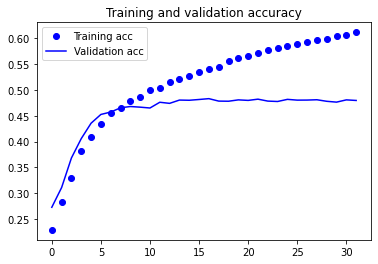

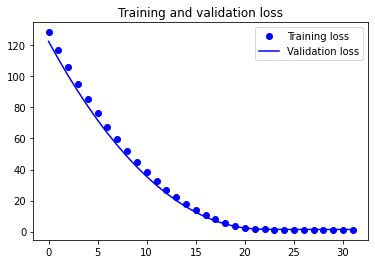

In [33]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
# Save the Model
modelBidirectionalLSTMGRU9.save('modelBidirectionalLSTMGRU9.h5')

### 10. Final Model: Add more regularization + Decrease Network Size & Batch Size + Glove Embedding

In [13]:
maxlen = 50
max_features = 15000

In [14]:
glove_dir = 'C:\\Users\\shiny\\Desktop\\DL\\ASG2'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [15]:
embedding_dim = 50

embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_features:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [24]:
modelBidirectionalLSTMGRU10 = Sequential()

modelBidirectionalLSTMGRU10.add(Embedding(max_features, embedding_dim, input_length=50))
modelBidirectionalLSTMGRU10.add(Bidirectional(layers.LSTM(128, return_sequences=True)))
modelBidirectionalLSTMGRU10.add(layers.Dropout(0.6))
modelBidirectionalLSTMGRU10.add(Bidirectional(layers.LSTM(128, return_sequences=True,
                                                        kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005))))
modelBidirectionalLSTMGRU10.add(layers.Dropout(0.6))
modelBidirectionalLSTMGRU10.add(Bidirectional(layers.LSTM(64, return_sequences=True, 
                                                         kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005))))
modelBidirectionalLSTMGRU10.add(layers.Dropout(0.6))
modelBidirectionalLSTMGRU10.add(Bidirectional(layers.GRU(128, return_sequences=True)))
modelBidirectionalLSTMGRU10.add(layers.Dropout(0.6))
modelBidirectionalLSTMGRU10.add(Bidirectional(layers.GRU(128, return_sequences=True,
                                                       kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005))))
modelBidirectionalLSTMGRU10.add(layers.Dropout(0.6))
modelBidirectionalLSTMGRU10.add(Bidirectional(layers.GRU(64, return_sequences=False, 
                                                         kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005))))
modelBidirectionalLSTMGRU10.add(layers.Dropout(0.6))
modelBidirectionalLSTMGRU10.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.01)))
modelBidirectionalLSTMGRU10.add(layers.Dropout(0.4))
modelBidirectionalLSTMGRU10.add(Dense(5, activation='softmax', kernel_regularizer = regularizers.l2(0.01)))
modelBidirectionalLSTMGRU10.layers[0].set_weights([embedding_matrix])
modelBidirectionalLSTMGRU10.layers[0].trainable = True
optimizer = optimizers.Adam(learning_rate = 0.00002)
modelBidirectionalLSTMGRU10.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics =['acc'])
modelBidirectionalLSTMGRU10.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 50)            750000    
                                                                 
 bidirectional_32 (Bidirecti  (None, 50, 256)          183296    
 onal)                                                           
                                                                 
 dropout_35 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_33 (Bidirecti  (None, 50, 256)          394240    
 onal)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_34 (Bidirecti  (None, 50, 128)         

In [26]:
# Train the Model
earlystopping = callbacks.EarlyStopping(monitor='val_acc', mode='max', patience = 15)
history = modelBidirectionalLSTMGRU10.fit(x_train, y_train,
          batch_size=64,
          epochs=50,
          validation_split=0.2,
          callbacks=[earlystopping])

Epoch 1/50
500/500 [==============================] - 68s 105ms/step - loss: 224.2453 - acc: 0.2438 - val_loss: 196.5657 - val_acc: 0.3027
Epoch 2/50
500/500 [==============================] - 50s 99ms/step - loss: 171.5111 - acc: 0.2699 - val_loss: 147.5978 - val_acc: 0.2960
Epoch 3/50
500/500 [==============================] - 52s 104ms/step - loss: 126.2393 - acc: 0.2745 - val_loss: 106.0186 - val_acc: 0.2858
Epoch 4/50
500/500 [==============================] - 53s 107ms/step - loss: 88.3124 - acc: 0.2837 - val_loss: 71.7396 - val_acc: 0.3139
Epoch 5/50
500/500 [==============================] - 54s 109ms/step - loss: 57.5890 - acc: 0.3289 - val_loss: 44.5476 - val_acc: 0.3385
Epoch 6/50
500/500 [==============================] - 54s 108ms/step - loss: 34.0054 - acc: 0.3357 - val_loss: 24.5921 - val_acc: 0.3545
Epoch 7/50
500/500 [==============================] - 55s 109ms/step - loss: 17.6371 - acc: 0.3461 - val_loss: 11.7730 - val_acc: 0.3587
Epoch 8/50
500/500 [================

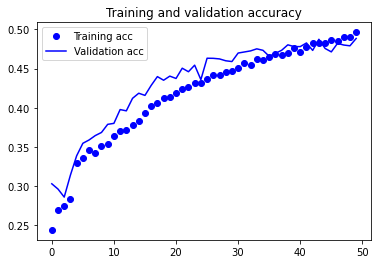

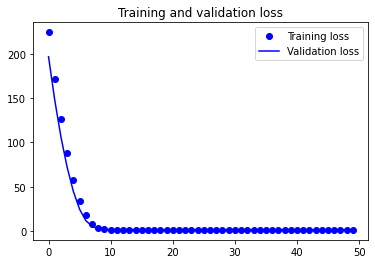

In [27]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
# Save the Model
modelBidirectionalLSTMGRU10.save('modelBidirectionalLSTMGRU10.h5')